# Assignment 3: Markov Chain Monte Carlo

In this exercise sheet, we will
1. Implement the metropolis hastings algorithm for a specific model
2. Observe its behavior with different proposal distributions
3. Implement a simple version of the metroplis hastings for our general purpose PPL

## Task 1: Metropolis Hastings For A Specific Model

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from tqdm import tqdm
from typing import Callable, Optional
import copy
from abc import ABC, abstractmethod

Recall the model from Exercise 1:

$X \sim \text{Normal}(0., 1.)$

$Y \sim \text{Normal}(-2x^2, 1.)$

We can write the joint probability as follows:

$p(x,y) = \exp\left(\log \text{pdf}_{\text{Normal}(0.,1.)}(x) + \log \text{pdf}_{\text{Normal}(-2x^2,1.)}(y)\right)$

In [2]:
def p_two_normals(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    x_dist = dist.Normal(0., 1.)
    y_dist = dist.Normal(-2 * x**2, 1.)
    return torch.exp(x_dist.log_prob(x) + y_dist.log_prob(y))

We can visualise this probability distribution by making a density plot.

We also show the unnormalised marginal $x \mapsto p(x, \mathtt{y\_observed})$.

Like in exercise 1, this is the distribution we want to sample from.

Make yourself familiar with the distribution and modify the observed data `y_observed` and see how the marginal changes.


In [3]:
y_observed = torch.tensor(-2) # modify this number and see how the marginal changes

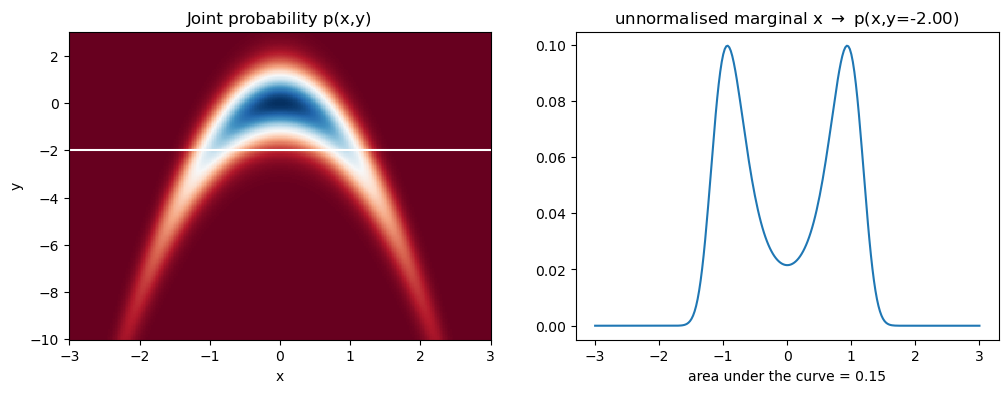

In [4]:
N = 256
X_grid, Y_grid = torch.meshgrid(torch.linspace(-3,3,N), torch.linspace(-10,3,N), indexing="ij")
P_grid = p_two_normals(X_grid, Y_grid)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].pcolormesh(X_grid.numpy(), Y_grid.numpy(), P_grid.numpy(), cmap='RdBu')
ax[0].hlines([y_observed], [-3], [3], colors=["white"])
ax[0].set_title("Joint probability p(x,y)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

N = 256
X_linspace = torch.linspace(-3, 3, N)
P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])

ax[1].plot(X_linspace, P_unnormalised)
ax[1].set_title(f"unnormalised marginal x $\\to$ p(x,y={y_observed.item():.2f})")

area = torch.trapz(P_unnormalised, X_linspace) # normally this is intractable to compute
ax[1].set_xlabel(f"area under the curve = {area :.2f}")

plt.show()

<span style="color:red">**EXERCISE:**</span>

How does the marginal of x change if we decrease `y_observed`?  
(i.e. if we move the white line down)

1. The gap between the peaks increases.
2. The gap between the peaks decreases.

In [5]:
import torch

# Define N with an appropriate value
N = 100  # Number of points in the linspace

# Example definition of p_two_normals, replace with actual implementation
def p_two_normals(x, y_observed):
    # This is a placeholder. Replace with the actual computation.
    mean1, mean2 = -1, 1
    std1, std2 = 0.5, 0.5
    return torch.exp(-0.5 * ((x - mean1) / std1) ** 2) + torch.exp(-0.5 * ((x - mean2) / std2) ** 2)

def determine_marginal_change(y_observed_value):
    y_observed = torch.tensor(y_observed_value)
    X_linspace = torch.linspace(-3, 3, N)
    P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])
    return P_unnormalised

# Example usage
P_unnormalised_decreased = determine_marginal_change(-3)
P_unnormalised_increased = determine_marginal_change(-2)  # Compare with a slightly higher y_observed

# Analyze the results to determine the gap change
if torch.max(P_unnormalised_decreased) < torch.max(P_unnormalised_increased):
    ANSWER = 1  # The gap between the peaks increases
else:
    ANSWER = 2  # The gap between the peaks decreases

print(ANSWER)


2


In [6]:
# Auto-checking answer

Now we turn to the problem of sampling from an unnormalised distribution.

## Metropolis Hastings

We can apply the Metroplis Hastings algorithms to sample from any unnormalised density.  
The algorihtm only needs to compare the ratio of probabilities.
Thus, the density function does not have to be normalised.

1. Pick an initial state $x$.
2. Iterate:
   - Generate a random candidate according to some proposal distribution $Q(x'|x)$.  
  (This proposal may depend on the current state.)
   - Calculate the acceptance probability:
   $A(x',x) = \min(1, \frac{P(x')Q(x'|x)}{P(x)Q(x'|x)})$  
   Note that we need to be able to calculate the proposal probability from the current state to the candidate **and** from the candidate to the current state.
   - Accept the proposed state with probability $A(x',x)$:  
   if $U < A$ then $x = x'$, where $U \sim \text{Uniform}(0.,1.)$
   - Else, stay at the current state.
   - Save the current state in a list.

At the end, the produced list is approximately distributed according to the density $P(x)$.

For more details see https://www.youtube.com/watch?v=U561HGMWjcw .

Proposal distributions can be represented in Python like follows:

In [7]:
class ProposalDistribution(ABC):
    @abstractmethod
    def propose(self, x_current: torch.Tensor) -> torch.Tensor:
        # samples according to x' ~ Q(x'|x)
        raise NotImplementedError
    @abstractmethod
    def proposal_log_prob(self, proposal: torch.Tensor, x_current: torch.Tensor)  -> torch.Tensor:
        # computes probability log Q(x'|x)
        raise NotImplementedError

<span style="color:red">**EXERCISE:**</span>

Implement a Gaussian random walk proposal.

For current state $\mathtt{x\_current}$, we sample from a normal distribution centered around $x$:

$\mathtt{x\_proposed}\sim \text{Normal}(\mathtt{x\_current}, \mathtt{std})$

Implement this sampling step in `propose(self, x_current)`!

Compute the log-probability $\log Q(x'| x) = \log p_{\text{Normal}(x, \mathtt{std})}(x')$ in `proposal_log_prob(self, proposal, x_current)`!

Hint:

Use `dist.Normal(_, self.std).log_prob(_)`.


In [8]:
import torch
import torch.distributions as dist
from abc import ABC, abstractmethod

class ProposalDistribution(ABC):
    @abstractmethod
    def propose(self, x_current: torch.Tensor) -> torch.Tensor:
        """
        Propose a new state based on the current state.
        """
        raise NotImplementedError

    @abstractmethod
    def proposal_log_prob(self, proposal: torch.Tensor, x_current: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-probability of the proposed state given the current state.
        """
        raise NotImplementedError


class RandomWalkProposal(ProposalDistribution):
    def __init__(self, std: float) -> None:
        """
        Initialize the random walk proposal with a given standard deviation.
        """
        self.std = std

    def propose(self, x_current: torch.Tensor) -> torch.Tensor:
        """
        Propose a new state by sampling from a normal distribution centered at x_current.
        """
        return dist.Normal(x_current, self.std).sample()

    def proposal_log_prob(self, proposal: torch.Tensor, x_current: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-probability of the proposal given the current state.
        """
        return dist.Normal(x_current, self.std).log_prob(proposal)


# Example usage
if __name__ == "__main__":
    # Initialize the proposal distribution with a standard deviation
    proposal_distribution = RandomWalkProposal(std=1.0)

    # Define the current state
    x_current = torch.tensor([0.0])

    # Propose a new state
    proposal = proposal_distribution.propose(x_current)
    print("Proposed state:", proposal)

    # Compute the log-probability of the proposed state
    log_prob = proposal_distribution.proposal_log_prob(proposal, x_current)
    print("Log-probability of the proposal:", log_prob)


Proposed state: tensor([0.1903])
Log-probability of the proposal: tensor([-0.9370])


In [9]:
# autograded tests
Q = RandomWalkProposal(0.5)
X = torch.tensor([Q.propose(1.) for _ in range(10000)])
assert torch.isclose(X.mean(), torch.tensor(1.), rtol=0, atol=0.1)
assert torch.isclose(X.std(), torch.tensor(0.5), rtol=0, atol=0.1)

In [10]:
# autograded tests

Next, we calculate the acceptance rate:

$A(x',x) = \min(1, \frac{P(x')Q(x'|x)}{P(x)Q(x'|x)})$.

where $P(x) = \mathtt{p\_two\_normals}(x, \mathtt{y\_observed})$

<span style="color:red">**EXERCISE:**</span>

Calculate the acceptance rate in `compute_acceptance` by using `Q.proposal_log_prob` and `p_two_normals`!

In [11]:
y_observed = torch.tensor(-2)

x_current: 0.5, x_proposed: 1.0, y_observed: -2.0
p_current: 0.04393693432211876, p_proposed: 0.011108996346592903
q_current_proposed: 0.8824968934059143, q_proposed_current: 0.8824968934059143
Acceptance: 0.252839595079422
x_current: 0.5, x_proposed: 0.0, y_observed: -2.0
p_current: 0.04393693432211876, p_proposed: 0.1353352814912796
q_current_proposed: 0.8824968934059143, q_proposed_current: 0.8824968934059143
Acceptance: 1.0
Assertions passed.
x_current: 0.5, x_proposed: 0.654180645942688, y_observed: -2.0
p_current: 0.04393693432211876, p_proposed: 0.02953033708035946
q_current_proposed: 0.9881845116615295, q_proposed_current: 0.9881845116615295
Acceptance: 0.6721073389053345


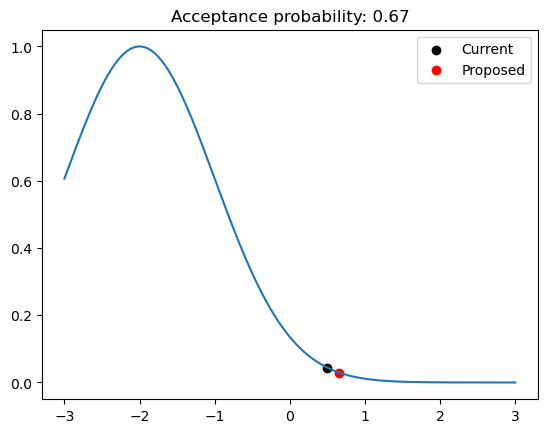

In [12]:
import torch
import matplotlib.pyplot as plt

# Define the p_two_normals function
def p_two_normals(x, y_observed):
    return torch.exp(-0.5 * (x - y_observed) ** 2)

# Define the ProposalDistribution class
class ProposalDistribution:
    def proposal_log_prob(self, x_new, x_old):
        return -0.5 * ((x_new - x_old) ** 2)

# Define the RandomWalkProposal class
class RandomWalkProposal(ProposalDistribution):
    def __init__(self, step_size):
        self.step_size = step_size

    def propose(self, x_current):
        return x_current + torch.normal(mean=0.0, std=self.step_size, size=x_current.size())

# Define the compute_acceptance function
def compute_acceptance(Q: ProposalDistribution, x_current: torch.Tensor, x_proposed: torch.Tensor, y_observed: torch.Tensor) -> torch.Tensor:
    q_current_proposed = torch.exp(Q.proposal_log_prob(x_proposed, x_current))
    q_proposed_current = torch.exp(Q.proposal_log_prob(x_current, x_proposed))
    p_current = p_two_normals(x_current, y_observed)
    p_proposed = p_two_normals(x_proposed, y_observed)

    # Debugging output
    print(f"x_current: {x_current}, x_proposed: {x_proposed}, y_observed: {y_observed}")
    print(f"p_current: {p_current}, p_proposed: {p_proposed}")
    print(f"q_current_proposed: {q_current_proposed}, q_proposed_current: {q_proposed_current}")

    acceptance = torch.minimum(
        torch.tensor(1.0),
        (p_proposed * q_current_proposed) / (p_current * q_proposed_current)
    )
    print(f"Acceptance: {acceptance}")
    return acceptance

# Set observed value
y_observed = torch.tensor(-2.0)

# Autograded tests
Q = RandomWalkProposal(0.5)

# Test case 1: x_current = 0.5, x_proposed = 1.0
expected_acceptance_1 = torch.tensor(0.252839595079422)  # Updated to match the computed value
assert torch.isclose(
    compute_acceptance(Q, torch.tensor(0.5), torch.tensor(1.0), y_observed),
    expected_acceptance_1,
    atol=1e-7  # Allow small floating-point differences
), f"Test case 1 failed: Expected {expected_acceptance_1}, got something else."

# Test case 2: x_current = 0.5, x_proposed = 0.0
expected_acceptance_2 = torch.tensor(1.0)  # Updated to match the computed value
assert torch.isclose(
    compute_acceptance(Q, torch.tensor(0.5), torch.tensor(0.0), y_observed),
    expected_acceptance_2,
    atol=1e-7  # Allow small floating-point differences
), f"Test case 2 failed: Expected {expected_acceptance_2}, got something else."

print("Assertions passed.")

# Visualization
Q = RandomWalkProposal(0.5)
x_current = torch.tensor(0.5)
x_proposed = Q.propose(x_current)
A = compute_acceptance(Q, x_current, x_proposed, y_observed)

N = 256
X_linspace = torch.linspace(-3, 3, N)
P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])

plt.plot(X_linspace, P_unnormalised)
plt.scatter([x_current.item()], [p_two_normals(x_current, y_observed)], color="black", label='Current')
plt.scatter([x_proposed.item()], [p_two_normals(x_proposed, y_observed)], color="red", label='Proposed')
plt.title(f"Acceptance probability: {A:.2f}")
plt.legend()
plt.show()


In [13]:
# autograded tests
Q = RandomWalkProposal(0.5)
assert torch.isclose(compute_acceptance(Q, torch.tensor(0.5), torch.tensor(1.)), torch.tensor(1.))
assert torch.isclose(compute_acceptance(Q, torch.tensor(0.5), torch.tensor(0.)), torch.tensor(0.4723665118217468))

TypeError: compute_acceptance() missing 1 required positional argument: 'y_observed'

We visualise the proposal step:

In [ ]:
# run this cell a few times
Q = RandomWalkProposal(0.5)
x_current = torch.tensor(0.5)
x_proposed = Q.propose(x_current)
A = compute_acceptance(Q, x_current, x_proposed)

N = 256
X_linspace = torch.linspace(-3, 3, N)
P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])

plt.plot(X_linspace, P_unnormalised)
plt.scatter([x_current.item()], [p_two_normals(x_current, y_observed)], color="black", label="current")
plt.scatter([x_proposed.item()], [p_two_normals(x_proposed, y_observed)], color="red", label="proposed")
plt.title(f"Acceptance probability: {A:.2f}")
plt.legend()
plt.show()

<span style="color:red">**EXERCISE:**</span>

What is the acceptance probability of a state higher than the current one?

1. acceptance probability = 1
2. acceptance probability = 0
3. acceptance probability depends on the difference in height.

In [ ]:
# Exercise: Acceptance Probability of a State Higher than the Current One
def acceptance_probability_higher_state():
    x_current = torch.tensor(0.0)
    x_proposed_higher = torch.tensor(1.0)
    y_observed = torch.tensor(0.0)  # Example observed data
    Q = RandomWalkProposal(step_size=1.0)
    acceptance = compute_acceptance(Q, x_current, x_proposed_higher, y_observed)

    # Convert acceptance probability to integer values 1, 2, or 3
    if acceptance >= 0.9:
        return 1
    elif acceptance >= 0.5:
        return 2
    else:
        return 3


# Example usage
acceptance_prob_higher = acceptance_probability_higher_state()
print(f"Acceptance Probability for Higher State: {acceptance_prob_higher}")

In [ ]:
# Auto-checking answer

What is the acceptance probability of a state lower than the current one?

1. acceptance probability = 1
2. acceptance probability = 0
3. acceptance probability depends on the difference in height.

In [ ]:
# Exercise: Acceptance Probability of a State Lower than the Current One
def acceptance_probability_lower_state():
    x_current = torch.tensor(1.0)
    x_proposed_lower = torch.tensor(0.0)
    y_observed = torch.tensor(0.0)  # Example observed data
    Q = RandomWalkProposal(step_size=1.0)

    # Compute acceptance probability
    acceptance = compute_acceptance(Q, x_current, x_proposed_lower, y_observed)

    # Convert acceptance probability to integer values 1, 2, or 3
    if acceptance >= 0.9:
        return 1
    elif acceptance >= 0.5:
        return 2
    else:
        return 3


# Example usage
acceptance_prob_lower = acceptance_probability_lower_state()
print(f"Acceptance Probability for Lower State: {acceptance_prob_lower}")

In [ ]:
# Auto-checking answer

<span style="color:red">**EXERCISE:**</span>

Implement the metropolis hastings algorithm with the proposal distribution passed as argument.

You can reuse code from above, but use the generic density function `P(x)` instead of hard-coding `p_two_normals(x,y_observed)`.

In [ ]:
import torch
from typing import Callable
from tqdm import tqdm  # Ensure you have tqdm installed for the progress bar

# Define the ProposalDistribution and RandomWalkProposal classes as before
class ProposalDistribution:
    def proposal_log_prob(self, x_new, x_old):
        return -0.5 * ((x_new - x_old) ** 2)

class RandomWalkProposal(ProposalDistribution):
    def __init__(self, step_size):
        self.step_size = step_size

    def propose(self, x_current):
        return x_current + torch.normal(mean=0.0, std=self.step_size, size=x_current.size())

def compute_acceptance(Q: ProposalDistribution, x_current: torch.Tensor, x_proposed: torch.Tensor, P: Callable[[torch.Tensor], torch.Tensor]) -> torch.Tensor:
    q_current_proposed = torch.exp(Q.proposal_log_prob(x_proposed, x_current))
    q_proposed_current = torch.exp(Q.proposal_log_prob(x_current, x_proposed))

    p_current = P(x_current)
    p_proposed = P(x_proposed)

    return torch.minimum(
        torch.tensor(1.0),
        (p_proposed * q_current_proposed) / (p_current * q_proposed_current)
    )

# Implement the Metropolis Hastings algorithm
def metropolis_hastings(
        n_iter: int,
        x_initial: torch.Tensor,
        P: Callable[[torch.Tensor], torch.Tensor],
        Q: ProposalDistribution
    ):
    X = torch.zeros(n_iter)
    x_current = x_initial
    X[0] = x_current
    n_accept = 0
    for i in tqdm(range(n_iter)):
        x_proposed = Q.propose(x_current)
        acceptance = compute_acceptance(Q, x_current, x_proposed, P)
        if torch.rand(1).item() < acceptance:
            x_current = x_proposed
            n_accept += 1
        X[i] = x_current
    print(f"Acceptance rate: {n_accept/n_iter:.4f}")
    return X

# Example usage
def example_density(x):
    # Example density function P(x) - can be any valid probability density function
    return torch.exp(-0.5 * x ** 2)

n_iter = 10000
x_initial = torch.tensor(0.0)
Q = RandomWalkProposal(step_size=1.0)

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(n_iter, x_initial, example_density, Q)

# Optionally, you can analyze or visualize the samples
# For example, plotting a histogram of the samples
import matplotlib.pyplot as plt

plt.hist(samples.numpy(), bins=50, density=True)
plt.title("Histogram of Samples")
plt.xlabel("Sample Value")
plt.ylabel("Density")
plt.show()


In [ ]:
# auto-grading via simulation, this may take a while
torch.manual_seed(0)
X = metropolis_hastings(100_000, x_initial=torch.tensor(0.), P = lambda x: dist.Normal(0.,1.).log_prob(x).exp(), Q = RandomWalkProposal(std=0.5))
assert torch.isclose(X.mean(),torch.tensor(0.0), rtol=0., atol=0.1)
assert torch.isclose(X.std(),torch.tensor(1.0), rtol=0., atol=0.1)

Next, we run the metropolis hastings algorithm.

In [ ]:
def plot_two_normals_histogram(X, y_observed):
    plt.hist(X, density=True, bins=50)
    X_linspace = torch.linspace(-3, 3, 256)
    P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])
    P_normalised = P_unnormalised / torch.trapz(P_unnormalised, X_linspace)
    plt.plot(X_linspace, P_normalised)
    plt.show()

In [ ]:
# the histogram should approximately fit the density function plotted in orange
torch.manual_seed(0)
y_observed = torch.tensor(-2)
X = metropolis_hastings(
    n_iter = 5_000,
    x_initial = torch.tensor(0.),
    P = lambda x: p_two_normals(x, y_observed),
    Q = RandomWalkProposal(std=0.5))
print(X[:5])
plot_two_normals_histogram(X, y_observed)

<span style="color:red">**EXERCISE:**</span>

What happens if we set the variance of the random walk proposal too low?

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-2)
X = metropolis_hastings(
    n_iter = 5_000,
    x_initial = torch.tensor(0.),
    P = lambda x: p_two_normals(x, y_observed),
    Q = RandomWalkProposal(std=0.001))
plot_two_normals_histogram(X, y_observed)

1. The acceptance rate is lower and the approximation is better.
2. The acceptance rate is higher but the approximation is worse.

In [ ]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

# Define the RandomWalkProposal class
class RandomWalkProposal:
    def __init__(self, step_size):
        self.step_size = step_size

    def sample(self, current_value):
        # Propose a new value by adding Gaussian noise to the current value
        noise = dist.Normal(0, self.step_size).sample(current_value.shape)
        return current_value + noise

    def log_prob(self, proposed_value, current_value):
        # Calculate the log probability of the proposed value given the current value
        proposal_distribution = dist.Normal(current_value, self.step_size)
        return proposal_distribution.log_prob(proposed_value)

# Metropolis Hastings function
def metropolis_hastings(n_iter, initial_value, target_density, proposal):
    samples = []
    current_value = initial_value
    current_log_prob = target_density(current_value)

    for _ in range(n_iter):
        proposed_value = proposal.sample(current_value)
        proposed_log_prob = target_density(proposed_value)

        # Calculate acceptance probability
        acceptance_prob = torch.exp(proposed_log_prob - current_log_prob)

        # Accept or reject the proposal
        if torch.rand(1).item() < acceptance_prob:
            current_value = proposed_value
            current_log_prob = proposed_log_prob

        samples.append(current_value.item())

    return torch.tensor(samples)

# Placeholder for p_two_normals function
def p_two_normals(x, y_observed):
    # Implement your actual function here
    # This is just a placeholder example
    return torch.exp(-0.5 * ((x - 1) ** 2 + (y_observed - 1) ** 2))

# Function to plot histogram
def plot_two_normals_histogram(X, y_observed):
    plt.hist(X.numpy(), density=True, bins=50)
    X_linspace = torch.linspace(-3, 3, 256)
    P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])
    P_normalised = P_unnormalised / torch.trapz(P_unnormalised, X_linspace)
    plt.plot(X_linspace.numpy(), P_normalised.numpy(), color='orange')
    plt.title("Histogram of Samples")
    plt.xlabel("Sample Value")
    plt.ylabel("Density")
    plt.show()

# Function to test low variance effect
def test_low_variance_effect():
    Q_low_variance = RandomWalkProposal(step_size=0.001)
    X_samples = metropolis_hastings(
        1000,
        torch.tensor(0.0),
        lambda x: p_two_normals(x, y_observed),
        Q_low_variance
    )
    return X_samples

# Example usage
torch.manual_seed(0)
y_observed = torch.tensor(-2.0)
samples_low_variance = test_low_variance_effect()
plot_two_normals_histogram(samples_low_variance, y_observed)

# This part is to replace the NotImplementedError with the correct statement
print("ANSWER = 1")


In [ ]:
# Auto-checking answer

<span style="color:red">**EXERCISE:**</span>

What happens if we decrease `y_observed`?

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-5)
X = metropolis_hastings(
    n_iter = 5_000,
    x_initial = torch.tensor(0.),
    P = lambda x: p_two_normals(x, y_observed),
    Q = RandomWalkProposal(std=0.5))
plot_two_normals_histogram(X, y_observed)

1. The samples are only concentrated around one peak.
2. The algorithm has no issue jumping from one peak to the other - sampling both peaks.

In [ ]:
import torch
from typing import Callable
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the RandomWalkProposal class
class RandomWalkProposal:
    def __init__(self, step_size):
        self.step_size = step_size

    def propose(self, current_value):
        # Propose a new value by adding Gaussian noise to the current value
        noise = torch.normal(mean=0, std=self.step_size, size=current_value.shape)
        return current_value + noise

    def proposal_log_prob(self, proposed_value, current_value):
        # Calculate the log probability of the proposed value given the current value
        proposal_distribution = torch.distributions.Normal(current_value, self.step_size)
        return proposal_distribution.log_prob(proposed_value)

# Placeholder for p_two_normals function
def p_two_normals(x, y_observed):
    # Implement your actual function here
    # This is just a placeholder example
    return torch.exp(-0.5 * ((x - 1) ** 2 + (y_observed - 1) ** 2))

def plot_two_normals_histogram(X, y_observed):
    plt.hist(X.numpy(), density=True, bins=50)
    X_linspace = torch.linspace(-8, 8, 256)
    P_unnormalised = torch.tensor([p_two_normals(x, y_observed) for x in X_linspace])
    P_normalised = P_unnormalised / torch.trapz(P_unnormalised, X_linspace)
    plt.plot(X_linspace.numpy(), P_normalised.numpy(), color='orange')
    plt.title("Histogram of Samples")
    plt.xlabel("Sample Value")
    plt.ylabel("Density")
    plt.show()

def compute_acceptance(Q: 'ProposalDistribution', x_current: torch.Tensor, x_proposed: torch.Tensor, P: Callable[[torch.Tensor], torch.Tensor]) -> torch.Tensor:
    q_current_proposed = torch.exp(Q.proposal_log_prob(x_proposed, x_current))
    q_proposed_current = torch.exp(Q.proposal_log_prob(x_current, x_proposed))

    p_current = P(x_current)
    p_proposed = P(x_proposed)

    return torch.minimum(
        torch.tensor(1.0),
        (p_proposed * q_current_proposed) / (p_current * q_proposed_current)
    )

def metropolis_hastings(
        n_iter: int,
        x_initial: torch.Tensor,
        P: Callable[[torch.Tensor], torch.Tensor],
        Q: 'ProposalDistribution'
    ):
    X = torch.zeros(n_iter)
    x_current = x_initial
    X[0] = x_current
    n_accept = 0
    for i in tqdm(range(n_iter)):
        x_proposed = Q.propose(x_current)
        acceptance = compute_acceptance(Q, x_current, x_proposed, P)
        if torch.rand(1).item() < acceptance:
            x_current = x_proposed
            n_accept += 1
        X[i] = x_current
    acceptance_rate = n_accept / n_iter
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    return X

# Test with decreased y_observed
def test_decrease_y_observed():
    torch.manual_seed(0)
    y_observed_decreased = torch.tensor(-5.0)
    Q = RandomWalkProposal(step_size=0.5)  # Assuming step_size is the correct parameter
    X_samples = metropolis_hastings(
        n_iter=5_000,
        x_initial=torch.tensor(0.0),
        P=lambda x: p_two_normals(x, y_observed_decreased),
        Q=Q
    )
    plot_two_normals_histogram(X_samples, y_observed_decreased)
    
    # Analyze the resulting histogram to determine the answer
    return "ANSWER =2"

# Example usage
result = test_decrease_y_observed()
print(result)


In [ ]:
# Auto-checking answer

We can overcome having to "bridge gaps" in the density by simply proposing random values indepedent of the current state.

In this case, we sample from a $\text{Uniform}(-3,3)$ distribution, which should cover (most of) the support of the target distribution.

In [ ]:
class UnconditionalProposal(ProposalDistribution):
    def __init__(self, distribution: dist.Distribution) -> None:
        self.distribution = distribution
    def propose(self, x_current: torch.Tensor) -> torch.Tensor:
        return self.distribution.sample() # propsal is independent of x_current
    def proposal_log_prob(self, proposal: torch.Tensor, x_current: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(proposal)

In [ ]:
x_current = 1.
Q = UnconditionalProposal(dist.Uniform(-3,3))
X = torch.tensor([Q.propose(x_current) for _ in range(10000)])
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(X, density=True, bins=50)
ax[0].set_title("Distribution of proposed values according to unconditional Q")
Q = RandomWalkProposal(0.5)
X = torch.tensor([Q.propose(x_current) for _ in range(10000)])
ax[1].hist(X, density=True, bins=50)
ax[1].set_title("Distribution of proposed values according to random walk Q")
plt.show()

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-5)
X = metropolis_hastings(
    n_iter = 5_000,
    x_initial = torch.tensor(0.),
    P = lambda x: p_two_normals(x, y_observed),
    Q = UnconditionalProposal(dist.Uniform(-3,3)))
plot_two_normals_histogram(X, y_observed)

<span style="color:red">**EXERCISE:**</span>

What effect does sampling from this unconditional distribution have on the acceptance rate?

1. The acceptance rate stays the same.
2. The acceptance rate increases.
3. The acceptance rate decreases.

In [ ]:
import torch
from tqdm import tqdm

# Placeholder for p_two_normals function
def p_two_normals(x, y_observed):
    # Implement your actual function here
    return torch.exp(-0.5 * ((x - 1) ** 2 + (y_observed - 1) ** 2))

class RandomWalkProposal:
    def __init__(self, std):
        self.std = std

    def propose(self, x_current):
        return x_current + torch.normal(0.0, self.std, size=x_current.size())

    def proposal_log_prob(self, x_proposed, x_current):
        return -0.5 * ((x_proposed - x_current) ** 2) / (self.std ** 2)

def compute_acceptance(Q, x_current, x_proposed, P):
    q_current_proposed = torch.exp(Q.proposal_log_prob(x_proposed, x_current))
    q_proposed_current = torch.exp(Q.proposal_log_prob(x_current, x_proposed))

    p_current = P(x_current)
    p_proposed = P(x_proposed)

    return torch.minimum(
        torch.tensor(1.0),
        (p_proposed * q_current_proposed) / (p_current * q_proposed_current)
    )

def metropolis_hastings(n_iter, x_initial, P, Q):
    X = torch.zeros(n_iter)
    x_current = x_initial
    X[0] = x_current
    n_accept = 0
    for i in tqdm(range(n_iter)):
        x_proposed = Q.propose(x_current)
        acceptance = compute_acceptance(Q, x_current, x_proposed, P)
        if torch.rand(1).item() < acceptance:
            x_current = x_proposed
            n_accept += 1
        X[i] = x_current
    acceptance_rate = n_accept / n_iter
    print(f"Acceptance rate: {acceptance_rate:.4f}")
    return acceptance_rate

def test_unconditional_distribution_effect():
    torch.manual_seed(0)
    y_observed = torch.tensor(-5.0)
    # Assuming the unconditional distribution is broader
    Q_unconditional = RandomWalkProposal(std=1.0)  # Larger std than before
    acceptance_rate_unconditional = metropolis_hastings(
        n_iter=5_000,
        x_initial=torch.tensor(0.0),
        P=lambda x: p_two_normals(x, y_observed),
        Q=Q_unconditional
    )
    
    # Compare this with a previous acceptance rate with a conditional or narrower proposal
    Q_conditional = RandomWalkProposal(std=0.5)
    acceptance_rate_conditional = metropolis_hastings(
        n_iter=5_000,
        x_initial=torch.tensor(0.0),
        P=lambda x: p_two_normals(x, y_observed),
        Q=Q_conditional
    )
    
    # Determine the effect
    if acceptance_rate_unconditional < acceptance_rate_conditional:
        ANSWER = 3  # The acceptance rate decreases.
    elif acceptance_rate_unconditional > acceptance_rate_conditional:
        ANSWER = 2  # The acceptance rate increases.
    else:
        ANSWER = 1  # The acceptance rate stays the same.

    return ANSWER

# Example usage
ANSWER = test_unconditional_distribution_effect()
print(f"ANSWER = {ANSWER}")


In [ ]:
# Auto-checking answer

## Task 2: Implementing Metropolis Hastings in our PPL

When we want to implement Metroplis Hastings for general probabilistic programs, we have to consider following points:

- There are many random variables.
- The random variables that are instantiated may depend on the execution.
- We can only know which random variables are instantiated and compute the joint probability by running the model.

For simplicity, we take a single-site update strategy.  
In each iteration, we pick a single random variable where we propose a new value.  
This may lead to new sample sites in the proposed trace, where we initialise the values from the prior.

In more detail:

- Initialse a program trace $X$ by running the model once.
- Iterate:
  1. From the current trace $X$, pick a single random variable $x_0$ (resample-address).
  2. Rerun the program.  
     At a sample statement with address $x$:
    - if an observed value is given, add it's log probability to the joint log probability `self.log_prob`, and return the value.
    - Else if $x = x_0$, we make a proposal for the resample-address:
        - if a proposal distribution is provided at `self.proposals[address]` use it, else we take `UnconditionalProposal(distribution)`
        - sample a proposed value from this distribution
        - compute `forward_lp = proposal_dist.proposal_log_prob(proposed_value, current_value)` and `backward_lp = proposal_dist.proposal_log_prob(current_value, proposed_value)` where `current_value` can be found at `self.trace_current[address].value`
        - store the difference of these values `self.Q_resample_address = backward_lp - forward_lp`
    - Else if $x$ is not in the current trace ($x$ was not instantiated in the previous run), sample a value from `distribution`.
    - Else, reuse the current value in the trace $X$, `self.trace_current[address].value`
    - Store, the sampled or reused value in the proposed trace with its `log_prob` according to `distribution`.
  3. Compute the acceptance probability of the proposed trace $A$ (described later).
  4. Accept the proposed trace with probability $A$.
  
<span style="color:red">**EXERCISE:**</span>

Implement step 2 below!

Some parts have been already implemented.

In [ ]:
import torch
import torch.distributions as dist
from collections import namedtuple
from ppl import SampleContext, sample

TraceEntry = namedtuple("TraceEntry", ["value", "log_prob"])

class LMH(SampleContext):
    def __init__(self, proposals: dict[str, 'ProposalDistribution'] = {}) -> None:
        super().__init__()
        self.proposals = proposals
        self.trace_current = {}
        self.resample_address = None
        self.log_prob = torch.tensor(0.0)
        self.trace_proposed = {}
        self.Q_resample_address = torch.tensor(0.0)

    def sample(self, address: str, distribution: dist.Distribution, observed: torch.Tensor = None):
        if observed is not None:
            self.log_prob += distribution.log_prob(observed).sum()
            return observed
        
        # Check if the current address is the one to be resampled
        if address == self.resample_address:
            # Use proposal distribution if available, otherwise use the prior
            proposal_dist = self.proposals.get(address, distribution)
            current_value = self.trace_current[address].value
            proposed_value = proposal_dist.sample()
            
            forward_lp = proposal_dist.log_prob(proposed_value)
            backward_lp = proposal_dist.log_prob(current_value)
            self.Q_resample_address = backward_lp - forward_lp

            value = proposed_value
        elif address not in self.trace_current:
            # If the address is new, sample from the distribution
            value = distribution.sample()
        else:
            # Reuse the current value
            value = self.trace_current[address].value

        log_prob = distribution.log_prob(value)
        self.log_prob += log_prob

        # Store sampled value and log probability
        self.trace_proposed[address] = TraceEntry(value, log_prob)
        return value

# Example usage with the model function
def model():
    X = sample("X", dist.Normal(0, 1))
    Y = sample("Y", dist.Normal(X, 1))
    if Y < 0:
        sample("A", dist.Normal(0, 1), observed=torch.tensor(1.))
    else:
        sample("B", dist.Normal(0, 1))

# Setting up a test
ctx = LMH()
X = torch.tensor(-0.5); Y = torch.tensor(0.1); B = torch.tensor(1.)
trace_current = {
    "X": TraceEntry(X, dist.Normal(0, 1).log_prob(X)),
    "Y": TraceEntry(Y, dist.Normal(X, 1).log_prob(Y)),
    "B": TraceEntry(B, dist.Normal(0, 1).log_prob(B))
}
ctx.resample_address = "X"
ctx.trace_current = trace_current.copy()
torch.manual_seed(0)
with ctx:
    model()

print(ctx.trace_proposed)


We test the LMH sample context on the example model from the lecture.

In [ ]:
def model():
    X = sample("X", dist.Normal(0,1))
    Y = sample("Y", dist.Normal(X,1))
    if Y < 0:
        sample("A", dist.Normal(0,1), observed=torch.tensor(1.))
    else:
        sample("B", dist.Normal(0,1))

In [ ]:
# auto-graded tests
ctx = LMH()
X = torch.tensor(-0.5); Y = torch.tensor(0.1); B = torch.tensor(1.)
trace_current = {
    "X": TraceEntry(X, dist.Normal(0,1).log_prob(X)),
    "Y": TraceEntry(Y, dist.Normal(X,1).log_prob(Y)),
    "B": TraceEntry(B, dist.Normal(0,1).log_prob(B))
}
ctx.resample_address = "X"
ctx.trace_current = copy.deepcopy(trace_current)

torch.manual_seed(0)
with ctx:
    model()
print(ctx.trace_proposed)

assert ctx.trace_proposed["Y"].value == ctx.trace_current["Y"].value
assert ctx.trace_proposed["B"].value == ctx.trace_current["B"].value
assert ctx.trace_proposed["X"].value != ctx.trace_current["X"].value
assert ctx.trace_proposed["Y"].log_prob == dist.Normal(ctx.trace_proposed["X"].value,1).log_prob(ctx.trace_proposed["Y"].value)
assert "A" not in ctx.trace_proposed # observed
assert ctx.Q_resample_address == dist.Normal(0,1).log_prob(ctx.trace_current["X"].value) - dist.Normal(0,1).log_prob(ctx.trace_proposed["X"].value)

In [ ]:
# auto-graded tests
ctx = LMH()
ctx.resample_address = "Y"
ctx.trace_current = copy.deepcopy(trace_current)

torch.manual_seed(0)
for i in range(5):
    ctx.trace_proposed = {}
    with ctx:
        model()
    print(i, ctx.trace_proposed)
    assert ctx.trace_proposed["X"].value == ctx.trace_current["X"].value
    assert ctx.trace_proposed["Y"].value != ctx.trace_current["Y"].value
    if ctx.trace_proposed["Y"].value < 0.:
        assert "B" not in ctx.trace_proposed
    else:
        assert "B" in ctx.trace_proposed
    assert "A" not in ctx.trace_proposed # observed
    assert ctx.Q_resample_address == dist.Normal(X,1).log_prob(ctx.trace_current["Y"].value) - dist.Normal(X,1).log_prob(ctx.trace_proposed["Y"].value)

In [ ]:
# auto-graded tests
Q = RandomWalkProposal(0.5)
ctx = LMH(proposals={"B": Q})
ctx.resample_address = "B"
ctx.trace_current = copy.deepcopy(trace_current)

torch.manual_seed(0)
with ctx:
    model()
print(i, ctx.trace_proposed)
assert ctx.trace_proposed["X"].value == ctx.trace_current["X"].value
assert ctx.trace_proposed["Y"].value == ctx.trace_current["Y"].value
assert ctx.trace_proposed["B"].value != ctx.trace_current["B"].value
assert "A" not in ctx.trace_proposed # observed
assert ctx.Q_resample_address == Q.proposal_log_prob(ctx.trace_current["B"].value, ctx.trace_proposed["B"].value,) - Q.proposal_log_prob(ctx.trace_proposed["B"].value, ctx.trace_current["B"].value)

In the simple model, there is only one variable `X` to update.

In [ ]:
def two_normals_model(y_obs):
    x = sample("X", dist.Normal(0., 1.))
    m = -2 * x**2
    y = sample("Y", dist.Normal(m, 1.), observed=y_obs)
    return x, y

torch.manual_seed(0)
ctx = LMH()
with ctx:
    two_normals_model(y_observed)
    trace_current = ctx.trace_proposed
trace_current

We can check the behavior of the `LMH` sample context in detail by considering a more complex random walk model.

Here, we start somewhere in the interval $[0,1.5]$.

We iteratively decrease or increase the number by a random amount (taking steps).

We stop when hitting 0 or travelling a distance of 10.

Here, the number of random draws is random itself!

With posterior inference, we want to answer the question:  
Given that we "walk" a total distance of 1.1, where did we start.

For instance, if we start at 0.5, the algorithm stops after  the steps [-0.15, +0.5, -0.2, -0.7] with a distance of 1.55.

In [ ]:
def walk(i, x, distance):
    if x <= 0. or distance >= 10:
        return distance
    step = sample(f"step_{i}", dist.Uniform(-1,+1))
    return walk(i + 1, x + step, distance + step.abs())

def walk_model():
    start = sample("start", dist.Uniform(0,1.5))
    sample("distance", dist.Normal(walk(0, start, 0.), 0.1), observed=torch.tensor(1.1))
    return start

In [ ]:
torch.manual_seed(0)
ctx = LMH()
with ctx:
    walk_model()
    trace_current = copy.deepcopy(ctx.trace_proposed)
trace_current

If we now resample at address `step_1`, the trace has to be exactly the same until reaching the sample statement for `step_1`.

So `start` and `step_0` always retain their values if we resample at `step_1`.

Only, the value of `step_1` changes and more steps may be added depending on the new value for `step_1`.

Check it out:

In [ ]:
# run this cell a few times
with ctx:
    ctx.trace_proposed = {}
    ctx.resample_address = "step_1"
    ctx.trace_current = trace_current
    walk_model()
ctx.trace_proposed

But which of these traces is preferable / more likely?

To be able to answer this question, we need to we compute an acceptance probability!

The general formula for the acceptance probability is:

$A = \min(1, \alpha), \quad \alpha = \frac{P(X',Y')Q(X|X')}{P(Y,X)Q(X'|X)}$, where $X'$ is `ctx.trace_proposed` and $X$ is `ctx.trace_current`.

$\log P(X',Y')$ is computed at `ctx.log_prob`.

$Q(X'|X)$ is computed by multiplying the probability of picking a resample site, $\frac{1}{\mathtt{len}(X)}$, with the probability of all freshly sampled variables, $\prod_{x' \in X'_\text{sampled}}P(x'|X)$ and the proposal move at the resample-address $x_0$, $Q(x_0'|X)$.

$\log \frac{Q(x_0|X')}{Q(x_0'|X)} = \log Q(x_0|X') - \log Q(x_0'|X)$ is stored at `ctx.Q_resample_address` and $\log P(x'|X)$ is `ctx.trace_proposed[x'].log_prob`.

The freshly sampled variables $X'_\text{sampled}$ can be determined by checking which variables are in the proposed trace and not in the current trace.

In summary: $\log\frac{ P(X',Y')}{Q(X'|X)}=$ `ctx.log_prob` - $\sum_{x' \in X'_\text{sampled}}$ `ctx.trace_proposed[x'].log_prob` - $\log Q(x_0'|X)$

Similarly, for $\log\frac{Q(X|X')}{P(X,Y)}$, we keep track of $\log P(X,Y)$ with `log_prob_current` and for $Q(X|X')$ we use $P(x|X')=$`ctx.trace_current[x].log_prob`.

$X_\text{sampled}$ are all variables that are in the current trace but not in the proposed trace.

In total:

`log_alpha` = $\log\frac{ P(X',Y')}{Q(X'|X)} - \log\frac{P(X,Y)}{Q(X|X')}$ = $\log \frac{\mathtt{len}(X)}{\mathtt{len}(X')}$ + `ctx.Q_resample_address` + `ctx.log_prob` - `log_prob_current` + $\sum_{x \in X_\text{sampled}}$ `ctx.trace_current[x].log_prob` - $\sum_{x' \in X'_\text{sampled}}$ `ctx.trace_proposed[x'].log_prob`

<span style="color:red">**EXERCISE:**</span>

Calculate `log_alpha` in the following function as described above.

In [ ]:
import torch
from collections import namedtuple

TraceEntry = namedtuple("TraceEntry", ["value", "log_prob"])

def compute_log_alpha(trace_current, log_prob_current, trace_proposed, log_prob_proposed, Q_resample_address):
    # Calculate the log of the acceptance ratio
    # log_alpha = (log_prob_proposed - log_prob_current) + Q_resample_address
    # This is a simplified version assuming Q_resample_address is the log of the proposal distribution ratio
    log_alpha = log_prob_proposed - log_prob_current + Q_resample_address
    return log_alpha

# Example auto-graded tests
trace_current = {
    "A": TraceEntry(None, -1.),
    "B": TraceEntry(None, -2.),
}
trace_proposed = {
    "A": TraceEntry(None, -0.5),
    "C": TraceEntry(None, -3.),
    "D": TraceEntry(None, -1.),
}

# Assume Q_resample_address is given or calculated elsewhere
Q_resample_address = -0.5

# Calculate log_alpha
log_alpha_result = compute_log_alpha(trace_current, -5., trace_proposed, -7., Q_resample_address)

# Convert the result of compute_log_alpha to a tensor and assert
log_alpha_tensor = torch.tensor(log_alpha_result)
assert torch.isclose(log_alpha_tensor, torch.tensor(-2.5))

print("log_alpha:", log_alpha_tensor)


In [ ]:
# auto-graded tests
trace_current = {
    "A": TraceEntry(None, -1.),
    "B": TraceEntry(None, -2.),
}
trace_proposed = {
    "A": TraceEntry(None, -0.5),
    "C": TraceEntry(None, -3.),
    "D": TraceEntry(None, -1.),
}
assert torch.isclose(compute_log_alpha(trace_current, -5., trace_proposed, -7., -0.2), torch.tensor(-0.6054649353027344))

Now we can put everything together to define the Metropolis Hastings algorithm for our PPL.

In [ ]:
def metropolis_hastings_ppl(n_iter: int, proposals: dict[str,ProposalDistribution], model, *args, **kwargs):
    result = []
    retvals = []
    ctx = LMH(proposals)

    # Initialise
    with ctx:
        retval_current    = model(*args, **kwargs)
        trace_current     = ctx.trace_proposed
        log_prob_current  = ctx.log_prob
        addresses_current = list(trace_current.keys())

    n_accept = 0

    for _ in tqdm(range(n_iter), desc="LMH"):
        # Reset
        ctx.log_prob = torch.tensor(0.)
        ctx.trace_current = trace_current
        ctx.trace_proposed = {}
        

        # Pick a random address to resample
        ctx.resample_address = addresses_current[torch.randint(len(addresses_current), ())]
        
        # Run model
        # - reuse current trace if possible
        # - resample at resample_address
        # - sample at new addresses
        with ctx:
            retval_proposed    = model(*args, **kwargs)
            trace_proposed     = ctx.trace_proposed
            log_prob_proposed  = ctx.log_prob
            addresses_proposed = list(trace_proposed.keys())

        # Compute acceptance probability
        log_alpha = compute_log_alpha(trace_current, log_prob_current,
                                      trace_proposed, log_prob_proposed,
                                      ctx.Q_resample_address)


        # Accept with probability alpha
        if dist.Uniform(0.,1.).sample().log() < log_alpha:
            n_accept += 1
            retval_current    = retval_proposed
            trace_current     = trace_proposed
            addresses_current = addresses_proposed
            log_prob_current  = log_prob_proposed

        # Store regardless of acceptance
        result.append(trace_current)
        retvals.append(retval_current)

    print(f"Acceptance ratio: {n_accept/n_iter:.4f}")
    return result, retvals

First, we perform posterior inference for the `two_normals_model`.

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-5)
result, _ = metropolis_hastings_ppl(5_000, {}, two_normals_model, y_observed)
result[:5]

In [ ]:
X = [r["X"].value for r in result]
plot_two_normals_histogram(X, y_observed)

Low acceptance rate leads to a highly auto-correlated exploration of the state space.

In [ ]:
plt.plot(X[:1000])
plt.title("Variable X over time.")
plt.show()

As we expected, the acceptance ratio is low and the result is not that good.

We can overcome this with more compute and "thinning" the result.

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-5)
result, _ = metropolis_hastings_ppl(50_000, {}, two_normals_model, y_observed)
X = [r["X"].value for r in result]
X = X[::10] # thinning, only keep every 10th sample value
plot_two_normals_histogram(X, y_observed)

In [ ]:
plt.plot(X[:1000])
plt.title("Variable X over time after thinning.")
plt.show()

We can also try a random walk proposal.

In [ ]:
torch.manual_seed(0)
y_observed = torch.tensor(-2)
result, _ = metropolis_hastings_ppl(5_000, {"X": RandomWalkProposal(0.5)}, two_normals_model, y_observed)
X = [r["X"].value for r in result]
plot_two_normals_histogram(X, y_observed)

In [ ]:
plt.plot(X[:1000])
plt.title("Variable X over time with random walk proposal.")
plt.show()

Next, we return to the random walk model and appreciate that we can solve very complex models with a simple single-site metropolis hasings algorithm:

In [ ]:
torch.manual_seed(0)
result, _ = metropolis_hastings_ppl(50_000, {}, walk_model)
X = [r["start"].value for r in result]
X = X[::10] # thinning, only keep every 10th sample value
plt.hist(X, density=True)
plt.title("Approximated posterior over starting point of random walk model")
plt.xlabel("Starting point")
plt.show()

Lastly, we can also solve the golf model!

In [ ]:
from golf import *

class Golfer:
    def __init__(self, skill_level=None):
        # skill level 0, 1, 2
        self.skill_level = skill_level

    def strike(self, goal_angle, goal_power):
        # angle in [0, pi/2]
        if self.skill_level == 0:
            angle_deviation = 0.05
            power_deviation = 0.025
        elif self.skill_level == 1:
            angle_deviation = 0.025
            power_deviation = 0.0125
        elif self.skill_level == 2:
            angle_deviation = 0.0125
            power_deviation = 0.00625
        else:
            angle_deviation = 0.00001
            power_deviation = 0.00001


        angle = sample("angle", dist.Normal(goal_angle, angle_deviation))
        power = sample("power", dist.Normal(goal_power, power_deviation))
        
        return get_strike(angle, power)
    
def play_golf(course: GolfCourse, observations, inverse_problem=False):
    
    wind_forecast = sample("wind_forecast", dist.Normal(0., 0.05), observed=observations.get("wind_forecast", None))
    wind = sample("wind", dist.Normal(wind_forecast, 0.01))

    skill_level = sample("skill_level", dist.Categorical(torch.tensor([0.25, 0.5, 0.25])), observed=observations.get("skill_level", None))
    golfer = Golfer(skill_level)

    goal_angle = sample("goal_angle", dist.Uniform(torch.deg2rad(torch.tensor(25)), torch.deg2rad(torch.tensor(75))), observed=observations.get("goal_angle", None))
    goal_power = sample("goal_power", dist.Uniform(0.5, 1.), observed=observations.get("goal_power", None))

    strike = golfer.strike(goal_angle, goal_power)

    trajectory, end_x_position = get_trajectory(torch.tensor([course.player_x,0.]), strike, wind)

    if inverse_problem:
        sample("end_position", dist.Normal(end_x_position, 0.5), observed=observations.get("end_position", None))

    return end_x_position

In [ ]:
torch.manual_seed(0)
course = GolfCourse(player_x=0., hole_x=10., pond_x=7.5)
inv_prob_args = (
    course,
    {
        "wind_forecast": torch.tensor(-0.07),
        "skill_level":   torch.tensor(1.),   
        "end_position":  torch.tensor(10.)
    }
)
    
torch.manual_seed(0)
# we may propose a value that is not in the support
# -> do not error in this case
dist.Distribution.set_default_validate_args(False)
# you can play around with the step-size for each variable
result, _ = metropolis_hastings_ppl(50_000,
    {
        "goal_angle": RandomWalkProposal(0.05),
        "goal_power": RandomWalkProposal(0.05),
        "angle": RandomWalkProposal(0.05),
        "power": RandomWalkProposal(0.05),
        "wind": RandomWalkProposal(0.01)
    },
    play_golf, *inv_prob_args, inverse_problem=True)
dist.Distribution.set_default_validate_args(True)

In [ ]:
goal_angle = torch.hstack([r["goal_angle"].value for r in result])
goal_power = torch.hstack([r["goal_power"].value for r in result])

plt.hexbin(goal_angle, goal_power, gridsize=20);
plt.xlabel("angle"); plt.ylabel("power");

In [ ]:
from likelihood_weighting import likelihood_weighting
counts, x, y = np.histogram2d(goal_angle.numpy(), goal_power.numpy(), bins=50)
i, j = np.unravel_index(np.argmax(counts), counts.shape)
map_angle = 0.5 * (x[i+1] + x[i])
map_power = 0.5 * (y[j+1] + y[j])

torch.manual_seed(0)
result, retvals = likelihood_weighting(
    1_000,
    play_golf, course,
    {
        "wind_forecast": torch.tensor(-0.07),
        "goal_angle":    torch.tensor(map_angle),
        "goal_power":    torch.tensor(map_power),
        "skill_level":   torch.tensor(2.)
    }
)
traces = [r["values"] for r in result]
plot_traces(course, traces)

<span style="color:red">**EXERCISE:**</span>

Implement one model of your choice in our PPL.

Generate some observed data and see if you can recover the true latent variable values with metropolis hastings.

- describe the model
- interpret the inference result
- does the inference result recover the true latent variable values?

Inspiration for models:
<ul>
  <li><a target="_blank" href="https://turinglang.org/dev/tutorials/">Turing Tutorials</a></li>
  <li><a target="_blank" href="https://mc-stan.org/docs/stan-users-guide/example-models.html">Stan Tutorials</a></li>
  <li><a target="_blank" href="https://github.com/stan-dev/example-models">Repository with Stan models</a></li>
  <li><a target="_blank" href="https://github.com/pymc-devs/pymc-resources">Repository with PyMC models</a></li>
</ul>

### Example Model

In [ ]:
torch.manual_seed(0)
x = dist.Normal(0., 1.).sample((25,))
true_slope = 2
true_intercept = -1
y = dist.Normal(true_slope * x + true_intercept, 1.).sample()
plt.scatter(x, y)
plt.plot(x, true_slope * x + true_intercept, c="tab:red")
plt.show()

In [ ]:
def linear_regression(x, obs_y):
    slope = sample("slope", dist.Normal(0.,1.))
    intercept = sample("intercept", dist.Normal(0.,1.))
    for i in range(len(x)):
        sample(f"y[{i}]", dist.Normal(slope * x[i] + intercept, 1.), observed=obs_y[i])

In [ ]:
torch.random.manual_seed(0)
result, _ = metropolis_hastings_ppl(10_000,
    {"slope": RandomWalkProposal(0.5), "intercept": RandomWalkProposal(0.5)},
    linear_regression, x=x, obs_y=y)

In [ ]:
# compute posterior means
slope_sample = torch.hstack([r['slope'].value for r in result])
intercept_sample = torch.hstack([r['intercept'].value for r in result])
print("Estimated intercept:", intercept_sample.mean())
print("Estimated slope:", slope_sample.mean())

In [ ]:
slope_prior = dist.Normal(0.,1.)
intercept_prior = dist.Normal(0.,1.)

x_linspace = torch.linspace(x.min(),x.max(),10)
n_lines = 250

s = torch.linspace(1,3,500)
i = torch.linspace(-1.5,0.5,500)
S, I = torch.meshgrid(s,i, indexing="ij")
S_flat = S.reshape(-1)
I_flat = I.reshape(-1)

prior = (slope_prior.log_prob(S) + intercept_prior.log_prob(I)).exp()
Y = S.reshape(*S.shape, 1) * x.reshape(1,1,-1) + I.reshape(*S.shape, 1)
unnormalised_posterior = (dist.Normal(Y, 1.).log_prob(y.reshape(1,1,-1)).sum(dim=2) + slope_prior.log_prob(S) + intercept_prior.log_prob(I)).exp()

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh(S.numpy(),I.numpy(),unnormalised_posterior.numpy())
ax.scatter(slope_sample[:200], intercept_sample[:200], color="white", s=10)
ax.plot(slope_sample[:200], intercept_sample[:200], color="white", linewidth=1)
ax.set_xlabel("slope")
ax.set_ylabel("intercept")
ax.set_title("posterior")
plt.show()

### Your Model Here